In [ ]:
!pip install pandas_ta

In [ ]:
#Load libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Read the data
csv = pd.read_csv("/content/Volatility 75 Index_M1_20190101_20240131.csv",sep="\t")
csv

<DATE>    <TIME>     <OPEN>     <HIGH>      <LOW>    <CLOSE>  \
0        2019.01.01  05:02:00  110937.33  111089.72  110937.33  111056.37   
1        2019.01.01  05:03:00  111051.65  111101.00  111007.21  111007.21   
2        2019.01.01  05:04:00  111004.33  111012.99  110779.67  110793.21   
3        2019.01.01  05:05:00  110799.08  110905.32  110742.46  110875.05   
4        2019.01.01  05:06:00  110895.26  110923.05  110788.84  110788.84   
...             ...       ...        ...        ...        ...        ...   
2671269  2024.01.30  23:56:00  230929.37  231191.41  230877.33  230973.86   
2671270  2024.01.30  23:57:00  231012.99  231401.12  231012.99  231381.86   
2671271  2024.01.30  23:58:00  231469.83  231626.34  231364.70  231375.83   
2671272  2024.01.30  23:59:00  231393.24  231426.25  231257.89  231266.03   
2671273  2024.01.31  00:00:00  231306.25  231306.25  231103.13  231226.53   

         <TICKVOL>  <VOL>  <SPREAD>  
0               30      0      6000  
1               30      0      6000  
2               30      0      6000  
3               30      0      6000  
4               30      0      6000  
...            ...    ...       ...  
2671269         30      0      5200  
2671270         30      0      5200  
2671271         30      0      5200  
2671272         30      0      5200  
2671273         30      0      5200  

[2671274 rows x 9 columns]

In [ ]:
#Format the data
csv.rename(columns={"<DATE>":"date","<TIME>":"time","<TICKVOL>":"tickvol","<VOL>":"vol","<SPREAD>":"spread","<OPEN>":"open","<HIGH>":"high","<LOW>":"low","<CLOSE>":"close"},inplace=True)
csv.ta.sma(length= 60,append=True)
csv.dropna(inplace=True)
csv.reset_index(inplace=True)
csv

index        date      time       open       high        low  \
0             59  2019.01.01  06:01:00  111965.07  111981.22  111848.37   
1             60  2019.01.01  06:02:00  111890.44  111890.44  111744.30   
2             61  2019.01.01  06:03:00  111761.75  111826.88  111649.63   
3             62  2019.01.01  06:04:00  111665.14  111688.95  111536.92   
4             63  2019.01.01  06:05:00  111608.61  111890.55  111598.04   
...          ...         ...       ...        ...        ...        ...   
2671210  2671269  2024.01.30  23:56:00  230929.37  231191.41  230877.33   
2671211  2671270  2024.01.30  23:57:00  231012.99  231401.12  231012.99   
2671212  2671271  2024.01.30  23:58:00  231469.83  231626.34  231364.70   
2671213  2671272  2024.01.30  23:59:00  231393.24  231426.25  231257.89   
2671214  2671273  2024.01.31  00:00:00  231306.25  231306.25  231103.13   

             close  tickvol  vol  spread         SMA_60  
0        111895.95       30    0    6000  111432.886667  
1        111754.27       30    0    6000  111444.518333  
2        111673.29       30    0    6000  111455.619667  
3        111612.53       30    0    6000  111469.275000  
4        111890.55       30    0    6000  111486.200000  
...            ...      ...  ...     ...            ...  
2671210  230973.86       30    0    5200  232291.027833  
2671211  231381.86       30    0    5200  232238.174833  
2671212  231375.83       30    0    5200  232191.311167  
2671213  231266.03       30    0    5200  232141.510000  
2671214  231226.53       30    0    5200  232095.914000  

[2671215 rows x 11 columns]

In [ ]:
#Define the inputs
predictors = ["open","high","low","close","SMA_60"]

In [ ]:
#Scale the data
csv["open"] = csv["open"] /csv.loc[0,"open"]
csv["high"] = csv["high"] /csv.loc[0,"high"]
csv["low"] = csv["low"] /csv.loc[0,"low"]
csv["close"] = csv["close"] /csv.loc[0,"close"]
csv["SMA_60"] = csv["SMA_60"] /csv.loc[0,"SMA_60"]

In [ ]:
#Define the close
csv["Target Close"] = 0
csv["Target MA"] = 0

In [ ]:
#Define the forecast horizon
look_ahead = 60

In [ ]:
#Set the targets
csv.loc[csv["close"] > csv["close"].shift(-look_ahead) ,"Target Close"] = 0
csv.loc[csv["close"] < csv["close"].shift(-look_ahead) ,"Target Close"] = 1
csv.loc[csv["SMA_60"] > csv["SMA_60"].shift(-look_ahead) ,"Target MA"] = 0
csv.loc[csv["SMA_60"] < csv["SMA_60"].shift(-look_ahead) ,"Target MA"] = 1
csv = csv[:-look_ahead]

In [ ]:
#Get ready
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
#Time series split
splits = 10
gap = look_ahead
models_close = ["Logistic Regression","LDA","XGB","Nerual Net Simple","Nerual Net Large"]
models_ma = ["Logistic Regression","LDA","XGB","Nerual Net Simple","Nerual Net Large"]

In [ ]:
#Prepare the data
pca = PCA()
csv_reduced = pd.DataFrame(pca.fit_transform(csv.loc[:,predictors]))

In [ ]:
#Fit the model predicting close price
model_close = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model_close.fit(csv_reduced.loc[0:300000,:],csv.loc[0:300000,"Target Close"])
print("Close accuracy: ",accuracy_score(csv.loc[300070:,"Target Close"], model_close.predict(csv_reduced.loc[300070:,:])))

Close accuracy:  0.4990962620254304


In [ ]:
#Fit the model predicting the moving average
model_ma = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model_ma.fit(csv_reduced.loc[0:300000,:],csv.loc[0:300000,"Target MA"])
print("MA accuracy: ",accuracy_score(csv.loc[300070:,"Target MA"], model_ma.predict(csv_reduced.loc[300070:,:])))

MA accuracy:  0.6879839284668174


In [ ]:
#Error metrics
tscv = TimeSeriesSplit(n_splits=splits,gap=gap)
error_close_df = pd.DataFrame(index=np.arange(0,splits),columns=models_close)
error_ma_df = pd.DataFrame(index=np.arange(0,splits),columns=models_ma)

In [ ]:
#Training each model to predict changes in the close price
for i,(train,test) in enumerate(tscv.split(csv)):
    model= MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(20, 10), random_state=1)
    model.fit(csv_reduced.loc[train[0]:train[-1],:],csv.loc[train[0]:train[-1],"Target Close"])
    error_close_df.iloc[i,4] = accuracy_score(csv.loc[test[0]:test[-1],"Target Close"],model.predict(csv_reduced.loc[test[0]:test[-1],:]))

In [ ]:
error_close_df

Logistic Regression       LDA       XGB Nerual Net Simple Nerual Net Large
0             0.50346  0.510016  0.498905          0.503515         0.500369
1            0.482206  0.484395  0.494978          0.482272         0.484373
2             0.49588  0.511545  0.499708           0.49632         0.495847
3            0.502624  0.506177  0.500952          0.502305         0.502305
4             0.49753  0.498146  0.511952          0.502888         0.502228
5            0.521996  0.519246  0.497035          0.521182         0.508553
6            0.511292  0.509213  0.501821           0.52347         0.516826
7             0.48609  0.486288  0.497431           0.49907         0.497409
8            0.504076  0.505286  0.501777          0.494054         0.518663
9            0.491513  0.492569  0.501348          0.490358         0.490358

In [ ]:
#Training each model to predict changes in a technical indicator (in this example simple moving average) instead of close price.
for i,(train,test) in enumerate(tscv.split(csv)):
    model= MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(20, 10), random_state=1)
    model.fit(csv_reduced.loc[train[0]:train[-1],:],csv.loc[train[0]:train[-1],"Target MA"])
    error_ma_df.iloc[i,4] = accuracy_score(csv.loc[test[0]:test[-1],"Target MA"],model.predict(csv_reduced.loc[test[0]:test[-1],:]))

In [ ]:
#Our error metrics when predicting the indicator are much better
error_ma_df

Logistic Regression       LDA       XGB Nerual Net Simple Nerual Net Large
0            0.651684  0.687051  0.636283          0.686094         0.686831
1             0.68143  0.686281  0.623126          0.684664         0.679571
2            0.681716   0.68858  0.682662          0.688129           0.6822
3            0.661958  0.682376  0.647008          0.682035         0.551753
4            0.683212  0.691209  0.684279          0.691055         0.690978
5             0.67956  0.680495  0.672563          0.680759         0.679285
6            0.683091  0.685698  0.683014          0.682959         0.684851
7            0.692705  0.696402  0.693266          0.694796         0.696501
8            0.687007  0.688162  0.684026          0.686699         0.686655
9            0.692045  0.693112  0.678756          0.692155         0.531358

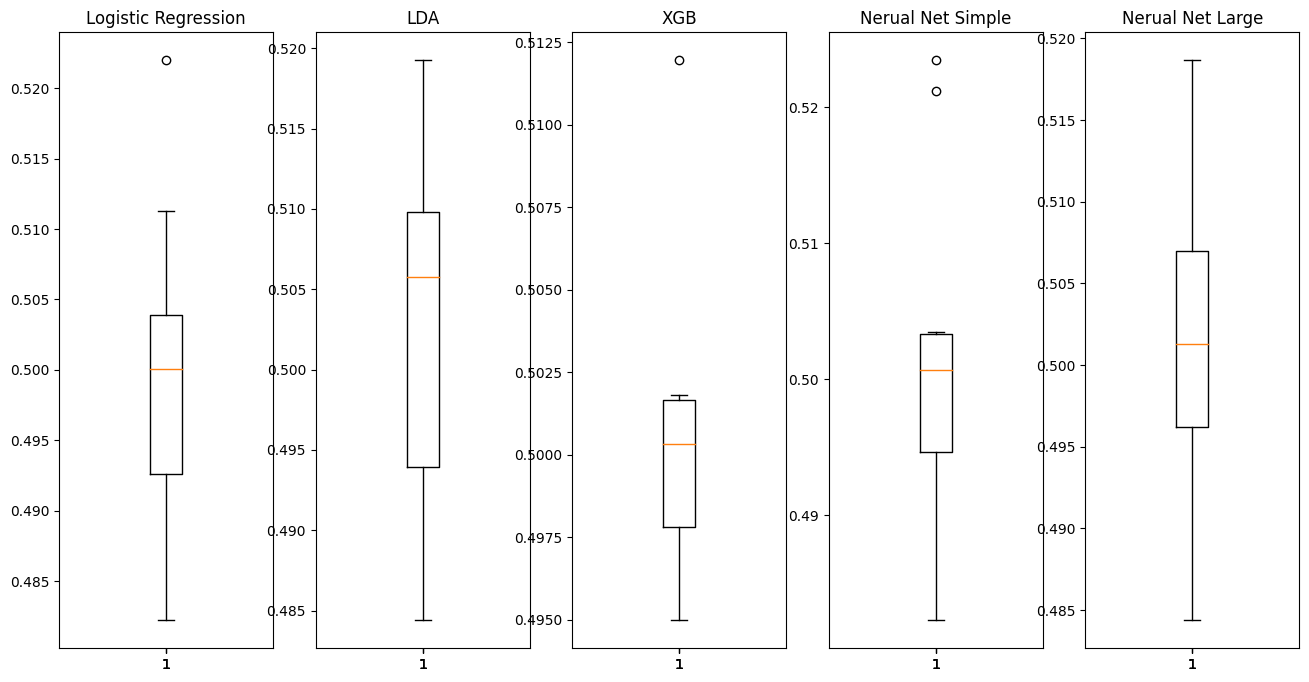

In [ ]:
fig , axs = plt.subplots(1,5,figsize=(16,8),sharex=True)

for i,ax in enumerate(axs.flat):
    ax.boxplot(error_close_df.iloc[:,i])
    ax.set_title(error_close_df.columns[i])

In [ ]:
for i in enumerate(np.arange(0,error_close_df.shape[1])):
  print(error_close_df.columns[i[0]]," ", error_close_df.iloc[:,i[0]].max())

Logistic Regression   0.5219959737302399
LDA   0.5192457894678943
XGB   0.5119523008041539
Nerual Net Simple   0.5234700724948571
Nerual Net Large   0.5186627504042771


In [ ]:
for i in enumerate(np.arange(0,error_close_df.shape[1])):
  print(error_close_df.columns[i[0]]," ", error_close_df.iloc[:,i[0]].min())

Logistic Regression   0.48220630782262414
LDA   0.4843954544954512
XGB   0.49497816353695695
Nerual Net Simple   0.4822723122449204
Nerual Net Large   0.48437345302135243


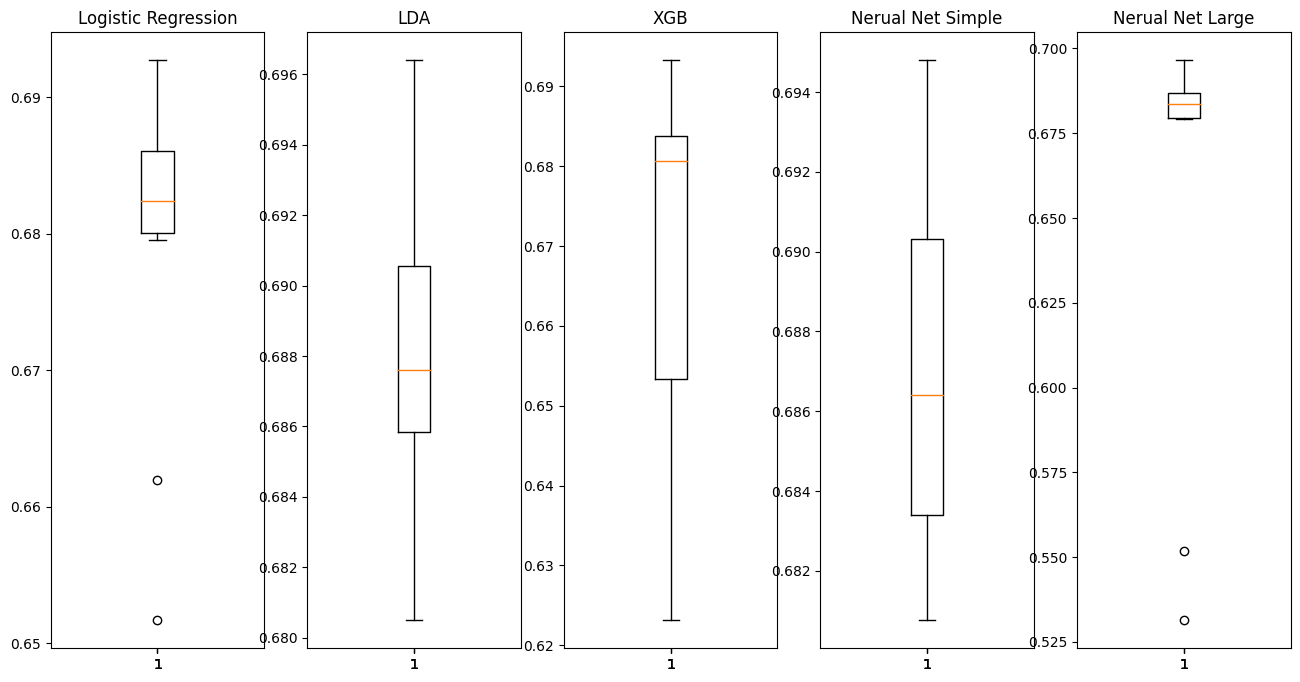

In [ ]:
fig , axs = plt.subplots(1,5,figsize=(16,8),sharex=True)

for i,ax in enumerate(axs.flat):
    ax.boxplot(error_ma_df.iloc[:,i])
    ax.set_title(error_ma_df.columns[i])

In [ ]:
for i in enumerate(np.arange(0,error_ma_df.shape[1])):
  print(error_ma_df.columns[i[0]]," ", error_ma_df.iloc[:,i[0]].max())

Logistic Regression   0.6927054112625546
LDA   0.696401658911147
XGB   0.6932664488520731
Nerual Net Simple   0.6947955513019373
Nerual Net Large   0.6965006655445914


In [ ]:
for i in enumerate(np.arange(0,error_ma_df.shape[1])):
  print(error_ma_df.columns[i[0]]," ", error_ma_df.iloc[:,i[0]].min())

Logistic Regression   0.651683662805408
LDA   0.6804945931377402
XGB   0.6231257494252115
Nerual Net Simple   0.6807586108269255
Nerual Net Large   0.5313576009592643


In [ ]:
#Import the libraries we need
import MetaTrader5 as mt5
import pandas_ta as ta
import pandas as pd

In [ ]:
#Trading global variables
MARKET_SYMBOL = 'Volatility 75 Index'

#This data frame will store the most recent price update
last_close = pd.DataFrame()

#We may not always enter at the price we want, how much deviation can we tolerate?
DEVIATION = 10000

#We will always enter at the minimum volume
VOLUME = 0
#How many times the minimum volume should our positions be
LOT_MUTLIPLE = 1

#What timeframe are we working on?
TIMEFRAME = mt5.TIMEFRAME_M1

#Which model have we decided to work with?
neural_network_model= MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

In [ ]:
#Determine the minimum volume
for index,symbol in enumerate(symbols):
    if symbol.name == MARKET_SYMBOL:
        print(f"{symbol.name} has minimum volume: {symbol.volume_min}")
        VOLUME = symbol.volume_min * LOT_MULTIPLE

In [ ]:
# function to send a market order
def market_order(symbol, volume, order_type, **kwargs):
    #Fetching the current bid and ask prices
    tick = mt5.symbol_info_tick(symbol)

    #Creating a dictionary to keep track of order direction
    order_dict = {'buy': 0, 'sell': 1}
    price_dict = {'buy': tick.ask, 'sell': tick.bid}

    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume,
        "type": order_dict[order_type],
        "price": price_dict[order_type],
        "deviation": DEVIATION,
        "magic": 100,
        "comment": "Indicator Forecast Market Order",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_FOK,
    }

    order_result = mt5.order_send(request)
    print(order_result)
    return order_result

In [ ]:
# Closing our order based on ticket id
def close_order(ticket):
    positions = mt5.positions_get()

    for pos in positions:
        tick = mt5.symbol_info_tick(pos.symbol) #validating that the order is for this symbol
        type_dict = {0: 1, 1: 0}  # 0 represents buy, 1 represents sell - inverting order_type to close the position
        price_dict = {0: tick.ask, 1: tick.bid} #bid ask prices

        if pos.ticket == ticket:
            request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "position": pos.ticket,
                "symbol": pos.symbol,
                "volume": pos.volume,
                "type": type_dict[pos.type],
                "price": price_dict[pos.type],
                "deviation": DEVIATION,
                "magic": 10000,
                "comment": "Indicator Forecast Market Order",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_FOK,
            }

            order_result = mt5.order_send(request)
            print(order_result)
            return order_result

    return 'Ticket does not exist'

In [ ]:
#Update our date from and date to
date_from = datetime(2023,11,1)
date_to = datetime.now()

In [ ]:
#Get signals from our glass-box model
def ai_signal():
    #Fetch OHLC data
    df = pd.DataFrame(mt5.copy_rates_range(market_symbol,TIMEFRAME,date_from,date_to))
    #Process the data
    df['time'] = pd.to_datetime(df['time'],unit='s')
    df['target'] = (df['close'].shift(-1) > df['close']).astype(int)
    preprocess(df)
    #Select the last row
    last_close = df.iloc[-1:,1:]
    #Remove the target column
    last_close.pop('target')
    #Use the last row to generate a forecast from our glass-box model
    #Remember 1 means buy and 0 means sell
    forecast = neural_network_model.predict(last_close)
    return forecast[0]

In [ ]:
#Let's create a function to preprocess our data
def preprocess(df):
    #All values of real_volume are 0 in this dataset
    df.drop(columns={'real_volume'},inplace=True)
    #Calculating 60 period moving average
    df.ta.ma(length=60,append=True)
    #Drop any rows that have missing values
    df.dropna(axis=0,inplace=True)

In [ ]:
#Now we define the main body of our Python Glass-box Trading Bot
if __name__ == '__main__':
    #We'll use an infinite loop to keep the program running
    while True:
        #Fetching model prediction
        signal = ai_signal()

        #Decoding model prediction into an action
        if signal == 1:
            direction = 'buy'
        elif signal == 0:
            direction = 'sell'

        print(f'AI Forecast: {direction}')

        #Opening A Buy Trade
        #But first we need to ensure there are no opposite trades open on the same symbol
        if direction == 'buy':
            #Close any sell positions
            for pos in mt5.positions_get():
                if pos.type == 1:
                    #This is an open sell order, and we need to close it
                    close_order(pos.ticket)

            if not mt5.positions_totoal():
                #We have no open positions
                market_order(MARKET_SYMBOL,VOLUME,direction)

        #Opening A Sell Trade
        elif direction == 'sell':
            #Close any buy positions
            for pos in mt5.positions_get():
                if pos.type == 0:
                    #This is an open buy order, and we need to close it
                    close_order(pos.ticket)

            if not mt5.positions_get():
                #We have no open positions
                market_order(MARKET_SYMBOL,VOLUME,direction)

        print('time: ', datetime.now())
        print('-------\n')
        time.sleep(60)